In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import journal_figure
from scipy.stats import pearsonr, spearmanr

method_name = "NoiseTunnel_Saliency"
model_name = "convnext"
path_template = f"./attribution_maps/{model_name}/{method_name}/image_{{i}}.npy"
epsilon = 1e-8

n_images = 50  # or len(test_dataset) if available

In [2]:
from PIL import Image 
def normalize_map(arr, target_size=(224,244)):
    """Normalize attribution map for fair comparison."""
    if arr.ndim == 2:
        arr = np.stack([arr]*3, axis=0)  # make 3 channels
    C, H, W = arr.shape

    if (H, W) != target_size:
        resized = []
        for c in range(C):
            img = Image.fromarray(arr[c].astype(np.float32))
            img = img.resize(target_size, resample=Image.BILINEAR)
            resized.append(np.array(img))
        arr = np.stack(resized, axis=0)

    arr = arr.astype(np.float32)
    arr -= arr.mean()
    arr /= (arr.std() + 1e-8)
    return arr


def channel_resize(arr, target_size=(224,244)):
    """Normalize attribution map for fair comparison."""
    if arr.ndim == 2:
        arr = np.stack([arr]*3, axis=0)  # make 3 channels
    C, H, W = arr.shape

    if (H, W) != target_size:
        resized = []
        for c in range(C):
            img = Image.fromarray(arr[c].astype(np.float32))
            img = img.resize(target_size, resample=Image.BILINEAR)
            resized.append(np.array(img))
        arr = np.stack(resized, axis=0)

    arr = arr.astype(np.float32)
    return arr
     
import torch
import lpips
def prep_for_lpips(arr):
    """Prepare tensor for LPIPS: 3xHxW in [-1,1]."""
    arr = normalize_map(arr)
    if arr.ndim == 2:
        arr = np.stack([arr]*3, axis=0)  # make 3 channels
    elif arr.shape[0] == 1:
        arr = np.repeat(arr, 3, axis=0)
    arr = np.clip(arr / (np.max(np.abs(arr)) + 1e-8), -1, 1)
    return torch.from_numpy(arr).unsqueeze(0)

In [3]:
def compute_all_similarities(map_i, map_j, epsilon=1e-8):
    map_i = normalize_map(map_i)
    map_j = normalize_map(map_j)
    diff = map_i - map_j

    l1 = float(np.mean(np.abs(diff))) 
    l2 = float(np.sqrt(np.mean(diff * diff))) 

    l1_sim = 1.0 / (1.0 + l1 + epsilon)
    l2_sim = 1.0 / (1.0 + l2 + epsilon)

    xi, xj = prep_for_lpips(map_i), prep_for_lpips(map_j)
    val = np.sqrt(lpips_model(xi, xj).item())
    lpips = 1.0 / (1+val + epsilon)

    return l1_sim, l2_sim, lpips

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lpips_model = lpips.LPIPS(net='alex').to(device)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/opt/homebrew/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /opt/homebrew/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth


In [5]:
l1_sims = []
l2_sims = []
lpips_sims = []

for i in range(n_images):
    map_i = normalize_map(np.load(path_template.format(i=i)))
    for j in range(i + 1, n_images):
        map_j = normalize_map(np.load(path_template.format(i=j)))
        l1_sim, l2_sim, lpips = compute_all_similarities(map_i, map_j)
        l1_sims.append(l1_sim)
        l2_sims.append(l2_sim)
        lpips_sims.append(lpips)

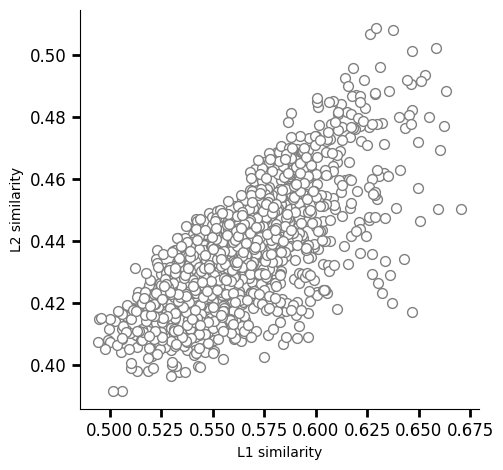

In [6]:
fig, ax = plt.subplots()

ax.scatter(l1_sims, l2_sims, s=50, edgecolor="grey", facecolor="white")

ax.set_xlabel("L1 similarity")
ax.set_ylabel("L2 similarity")

# plt.xlim(0., None)
# plt.ylim(0., None)

journal_figure()
plt.tight_layout()
# plt.savefig("figures/l1_vs_l2_similarity.eps")
plt.show()


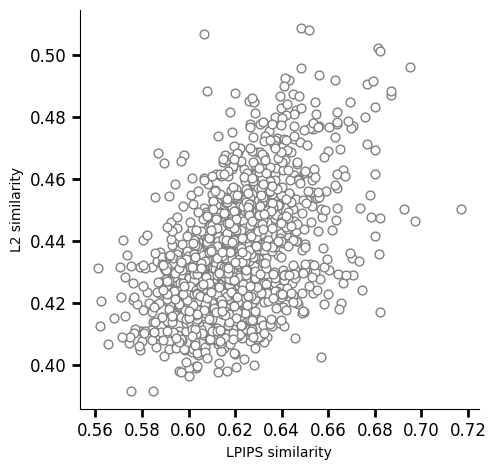

In [7]:
fig, ax = plt.subplots()

ax.scatter(lpips_sims, l2_sims, s=40, edgecolor="grey", facecolor="white")

ax.set_xlabel("LPIPS similarity")
ax.set_ylabel("L2 similarity")

# plt.xlim(0., None)
# plt.ylim(0., None)

journal_figure()
plt.tight_layout()
plt.savefig("figures/lpips_vs_l2_similarity.eps")
plt.show()


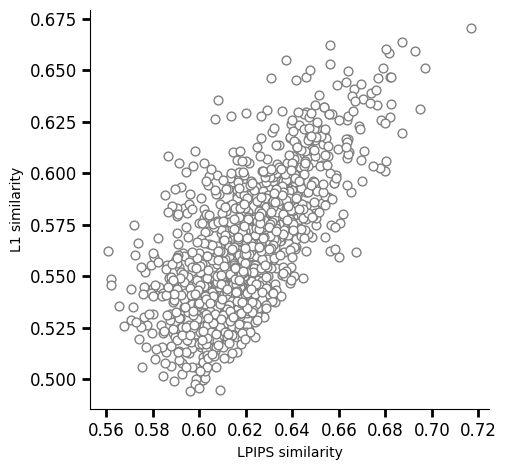

In [8]:
fig, ax = plt.subplots()

ax.scatter(lpips_sims, l1_sims, s=40, edgecolor="grey", facecolor="white")

ax.set_xlabel("LPIPS similarity")
ax.set_ylabel("L1 similarity")

# plt.xlim(0., None)
# plt.ylim(0., None)

journal_figure()
plt.tight_layout()
plt.savefig("figures/lpips_vs_l1_similarity.eps")
plt.show()


In [45]:
spearmanr(l1_sims, l2_sims), spearmanr(lpips_sims, l2_sims)

(SignificanceResult(statistic=np.float64(0.7034404887566772), pvalue=np.float64(1.4567658395110384e-183)),
 SignificanceResult(statistic=np.float64(0.4654241011249524), pvalue=np.float64(7.133872842432658e-67)))